[Boruta Algorithm Explained](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)

[Boruta implementation](https://towardsdatascience.com/feature-selection-with-boruta-in-python-676e3877e596)

[Feature Selection with Boruta package](https://www.datacamp.com/tutorial/feature-selection-R-boruta)

# Setup
Install packages, load data

## Install packages

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '../windowing_and_cv')  # Using the two dots ensures it starts from parent directory
from window_generator import WindowGenerator

## Load data

Add parent directory as path

In [2]:
sys.path.append('..')

In [3]:
raw_df = pd.read_csv("../data/dataset.csv", index_col=0, parse_dates=[0])
raw_df.head()

,VIX,T10Y3M,BAA10Y,DGS10,DCOILWTICO,DTWEXBGS,USEPUINDXD,WLEMUINDXD,BAMLC0A4CBBB,BAMLC0A1CAAA,...,MOM_5,MOM_10,RSI_5,RSI_10,BOLUP_5,BOLDOWN_5,BOLUP_10,BOLDOWN_10,ADX_5,ADX_10
2003-01-02,25.39,2.85,3.37,4.07,69.05,100.8803,324.67,188.18,2.67,1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-03,24.68,2.83,3.39,4.05,70.34,100.4474,357.74,148.90,2.64,1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-06,24.91,2.88,3.38,4.09,69.37,99.9413,166.02,295.76,2.61,0.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-07,25.13,2.85,3.39,4.04,68.28,100.3036,180.02,248.74,2.58,0.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-08,25.53,2.81,3.35,4.00,67.74,100.1151,204.91,81.20,2.57,0.96,...,NaN,NaN,NaN,NaN,25.819722,24.436278,NaN,NaN,NaN,NaN


Check for Nans

In [59]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VIX                     5217 non-null   float64
 1   T10Y3M                  5217 non-null   float64
 2   BAA10Y                  5217 non-null   float64
 3   DGS10                   5217 non-null   float64
 4   DCOILWTICO              5217 non-null   float64
 5   DTWEXBGS                5217 non-null   float64
 6   USEPUINDXD              5217 non-null   float64
 7   WLEMUINDXD              5217 non-null   float64
 8   BAMLC0A4CBBB            5217 non-null   float64
 9   BAMLC0A1CAAA            5217 non-null   float64
 10  BAMLC0A4CBBBEY          5217 non-null   float64
 11  BAMLC0A1CAAAEY          5217 non-null   float64
 12  BAMLC0A0CM              5217 non-null   float64
 13  BAMLC0A0CMEY            5217 non-null   float64
 14  DFII5                 

Some of the data is returns and technical indicators, thus should drop first day and untransformed data

In [4]:
# Set first day to 1 + first day
df = raw_df.iloc[10:].copy()
del raw_df
df.drop(columns=["DCOILWTICO", "DTWEXBGS", "Gold"], inplace=True)

**OPTIONAL**: Change to *Business Day* frequency. Should not introduce any NaNs in index, as demonstrated below

In [62]:
(df.asfreq("B").index == df.index).all()

True

# Boruta

## Setup

Split into train/val/test

In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_ind = int(n*0.7)
val_ind = int(n*0.9)
train_df = df[0:train_ind]
val_df = df[train_ind:val_ind]
test_df = df[val_ind:]

num_features = df.shape[1]

Create window with desired number of lags, denoted by input_width

In [6]:
input_width = 5
w = WindowGenerator(
    input_width=input_width, label_width=1, shift=1, label_columns=['VIX'], 
    train_df=train_df, val_df=val_df, test_df=test_df)
w

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['VIX']

In [7]:
train = w.train

x_train = np.concatenate([x for x, y in train], axis = 0)
y_train = np.concatenate([y for x, y in train], axis = 0)


In [8]:
x_train.shape

(3639, 5, 47)

In [9]:
x_train = x_train.reshape((len(x_train), -1))
x_train[0]

array([ 2.5010000e+01,  2.9200001e+00,  3.2900000e+00,  4.0999999e+00,
        1.1003000e+02,  7.4279999e+01,  2.5100000e+00,  9.3000001e-01,
        6.0300002e+00,  4.3499999e+00,  1.7400000e+00,  5.1599998e+00,
        1.7100000e+00,  2.3099999e+00,  1.4000000e+00,  1.7900000e+00,
        1.2400000e+00,  6.9563305e-01,  6.9331449e-01,  1.0100000e+00,
       -3.4000000e-01,  2.0000000e-01,  1.9000000e-01,  1.0400000e+00,
        1.1700000e+00,  1.1500000e+00,  6.9499731e-01,  2.9170001e-01,
        4.1670001e-01,  2.9170001e-01,  4.0992501e-01,  0.0000000e+00,
        1.0000000e+00,  2.4862000e+01,  2.4881001e+01,  2.4981533e+01,
        2.4934141e+01,  7.5999999e-01, -3.8000000e-01,  6.5702477e+01,
        4.6387833e+01,  2.5768797e+01,  2.3955204e+01,  2.5762083e+01,
        2.3999918e+01,  3.7367073e+01,  3.7367073e+01,  2.5700001e+01,
        2.8699999e+00,  3.2900000e+00,  4.0500002e+00,  3.3840000e+01,
        1.7767999e+02,  2.5300000e+00,  9.2000002e-01,  5.9899998e+00,
      

In [10]:
y_train = y_train.reshape((-1, ))
y_train.shape

(3639,)

Need to store label indices

In [11]:
cols = df.columns
flat_cols = []

for i in range(w.input_width, 0, -1):
    lag = f'_Lag_{i}'
    for col in cols:
        flat_cols.append(f'{col}{lag}')

flat_column_indices = {name: i for i, name in enumerate(flat_cols)}

In [77]:
flat_column_indices

{'VIX_Lag_5': 0,
 'T10Y3M_Lag_5': 1,
 'BAA10Y_Lag_5': 2,
 'DGS10_Lag_5': 3,
 'USEPUINDXD_Lag_5': 4,
 'WLEMUINDXD_Lag_5': 5,
 'BAMLC0A4CBBB_Lag_5': 6,
 'BAMLC0A1CAAA_Lag_5': 7,
 'BAMLC0A4CBBBEY_Lag_5': 8,
 'BAMLC0A1CAAAEY_Lag_5': 9,
 'BAMLC0A0CM_Lag_5': 10,
 'BAMLC0A0CMEY_Lag_5': 11,
 'DFII5_Lag_5': 12,
 'DFII10_Lag_5': 13,
 'T5YIE_Lag_5': 14,
 'T10YIE_Lag_5': 15,
 'EFFR_Lag_5': 16,
 'DCOILWTICO_R_Lag_5': 17,
 'DTWEXBGS_R_Lag_5': 18,
 'Mom_Lag_5': 19,
 'Mkt-RF_Lag_5': 20,
 'SMB_Lag_5': 21,
 'HML_Lag_5': 22,
 'ST_Rev_Lag_5': 23,
 '1MO_Lag_5': 24,
 '4WkBankDiscountRate_Lag_5': 25,
 'Gold_R_Lag_5': 26,
 'Bullish_Lag_5': 27,
 'Neutral_Lag_5': 28,
 'Bearish_Lag_5': 29,
 'Bullish 8-week Mov Avg_Lag_5': 30,
 'Bull-Bear Spread_Lag_5': 31,
 'Bull-Bear ratio_Lag_5': 32,
 'MA_5_Lag_5': 33,
 'MA_10_Lag_5': 34,
 'EMA_5_Lag_5': 35,
 'EMA_10_Lag_5': 36,
 'MOM_5_Lag_5': 37,
 'MOM_10_Lag_5': 38,
 'RSI_5_Lag_5': 39,
 'RSI_10_Lag_5': 40,
 'BOLUP_5_Lag_5': 41,
 'BOLDOWN_5_Lag_5': 42,
 'BOLUP_10_Lag_5': 43,

## Boruta

In [12]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

let's initialize a RF model 

In [13]:
model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)

let's initialize Boruta

In [14]:
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=250,  # number of iterations to perform
    perc=90
)

NOTE: When using numpy version 1.24, the below code will break due to deprecation of *np.int* and *np.float*. Two fixes are possible:
1. Downgrade to latest numpy version below 1.24, using `pip install "numpy<1.24"`
2. Clone the `Boruta` package locally from git, then alter the existing code.<br>

The second option is more complicated, thus the first option is preferred. If any dependencies crash, investigate option 2. 

### Run Boruta

First, must separate the data into corresponding folds for feature selection!

In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [27]:
num_samples = len(x_train)
n_splits = 5
train_splits = 3
test_splits = 1
tot_split = num_samples // (n_splits + 1 + train_splits + test_splits - 2)
m_train = tot_split * train_splits
m_test = tot_split * test_splits
tp = TimeSeriesSplit(n_splits=n_splits, max_train_size=m_train, test_size=m_test, )
print(tot_split)
print(m_train)
print(m_test)
print(f"Percentage: {m_test/(m_train+ m_test):.1%}")

454
1362
454
Percentage: 25.0%


Iterate over folds, and perform feature selection within each fold. Save the selected features

In [22]:
strong_support = {i:None for i in range(n_splits)}
weak_support = {i:None for i in range(n_splits)}
ranking = {i:None for i in range(n_splits)}

In [38]:
num = np.arange(num_samples)
folds = tp.split(num, num)

for i, fold in enumerate(folds):
    # Get data
    train_ind, val_ind = fold
    train_x = x_train[train_ind]
    train_y = y_train[val_ind]
    
    # Create model and boruta instance
    model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)
    feat_selector = BorutaPy(
        verbose=0,
        estimator=model,
        n_estimators='auto',
        max_iter=250,  # number of iterations to perform
        perc=90
    )
    
    # Run feature selection
    print(f"Started running Boruta on fold {i}")
    feat_selector.fit(x_train, y_train)
    print(f"Finished running Boruta on fold {i}")
    print("-"*20)
    # Save results
    strong_support[i] = feat_selector.support_.copy()
    weak_support[i] = feat_selector.support_weak_.copy()
    ranking[i] = feat_selector.ranking_.copy()
    
    
    # Delete model to clear up memory
    del feat_selector
    del model
    

Started running Boruta on fold 0
Finished running Boruta on fold 0
--------------------
Started running Boruta on fold 1
Finished running Boruta on fold 1
--------------------
Started running Boruta on fold 2
Finished running Boruta on fold 2
--------------------
Started running Boruta on fold 3
Finished running Boruta on fold 3
--------------------
Started running Boruta on fold 4
Finished running Boruta on fold 4
--------------------


In [39]:
strong_support

{0: array([False, False, False,  True, False, False,  True,  True, False,
         True,  True, False,  True, False, False,  True, False,  True,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False,  True, False, False,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False,  True, False,  True,
        False, False,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
   

In [57]:
ordered_cols = [i[:-6] for i in flat_cols[:47]]

In [65]:
iterables = [ordered_cols, ["Strong", "Weak", "Ranking"]]

multi = pd.MultiIndex.from_product(iterables, names=["feature", "results"])

In [66]:
support_df = pd.DataFrame(index=range(1, 6), columns=multi)
support_df.index.name = "Folds"

In [67]:
support_df

feature    VIX              T10Y3M              BAA10Y               DGS10  \
results Strong Weak Ranking Strong Weak Ranking Strong Weak Ranking Strong   
Folds                                                                        
1          NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN     NaN    NaN   
2          NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN     NaN    NaN   
3          NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN     NaN    NaN   
4          NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN     NaN    NaN   
5          NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN     NaN    NaN   

feature  ... BOLUP_10 BOLDOWN_10               ADX_5              ADX_10       \
results  ...  Ranking     Strong Weak Ranking Strong Weak Ranking Strong Weak   
Folds    ...                                                                    
1        ...      NaN        NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN   
2        ...      NaN        NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN   
3        ...      NaN        NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN   
4        ...      NaN        NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN   
5        ...      NaN        NaN  NaN     NaN    NaN  NaN     NaN    NaN  NaN   

feature          
results Ranking  
Folds            
1           NaN  
2           NaN  
3           NaN  
4           NaN  
5           NaN  

[5 rows x 141 columns]

In [80]:
for key, item in strong_support.items():
    weak = weak_support[key]
    rank = ranking[key]
    for i in range(len(flat_cols)):
        name = flat_cols[i][:-6]  # Drop num lags
        lags = flat_cols[i][-1]  # Number of lags
        if item[i]:
            prev_val = support_df.loc[key+1, (name, "Strong")]
            if pd.isnull(prev_val):
                support_df.loc[key+1, (name, "Strong")] = [lags]
            else:
                support_df.loc[key+1, (name, "Strong")] = prev_val.append(lags)
        if weak[i]:
            prev_val = support_df.loc[key+1, (name, "Weak")]
            if pd.isnull(prev_val):
                support_df.loc[key+1, (name, "Weak")] = [lags]
            else:
                support_df.loc[key+1, (name, "Weak")] = prev_val.append(lags)
            
        support_df.loc[key+1, (name, "Ranking")] = rank[i]

In [82]:
support_df.to_csv("../data/boruta_results.csv")

# To read results:

In [85]:
pd.read_csv("../data/boruta_results.csv", index_col=[0], header=[0,1])

feature    VIX              T10Y3M              BAA10Y               DGS10  \
results Strong Weak Ranking Strong Weak Ranking Strong Weak Ranking Strong   
Folds                                                                        
1        ['1']  NaN       1    NaN  NaN     160  ['3']  NaN     159  ['5']   
2        ['1']  NaN       1    NaN  NaN     136  ['3']  NaN     134  ['5']   
3        ['1']  NaN       1    NaN  NaN     138  ['3']  NaN     155  ['5']   
4        ['1']  NaN       1    NaN  NaN     151  ['3']  NaN     133  ['5']   
5        ['1']  NaN       1    NaN  NaN     144  ['3']  NaN     173  ['5']   

feature  ... BOLUP_10 BOLDOWN_10               ADX_5                ADX_10  \
results  ...  Ranking     Strong Weak Ranking Strong   Weak Ranking Strong   
Folds    ...                                                                 
1        ...        1        NaN  NaN     102  ['3']    NaN     122  ['3']   
2        ...        1        NaN  NaN      94    NaN  ['3']     147    NaN   
3        ...        1        NaN  NaN     113  ['3']    NaN      99  ['3']   
4        ...        1        NaN  NaN     131  ['3']    NaN     135  ['3']   
5        ...        1        NaN  NaN     139    NaN  ['3']     107  ['3']   

feature                 
results   Weak Ranking  
Folds                   
1          NaN     123  
2        ['3']     119  
3          NaN     108  
4          NaN     113  
5          NaN     114  

[5 rows x 141 columns]

In [98]:
feat_selector.fit(x_train, y_train)

Iteration: 	1 / 250
Confirmed: 	0
Tentative: 	235
Rejected: 	0
Iteration: 	2 / 250
Confirmed: 	0
Tentative: 	235
Rejected: 	0
Iteration: 	3 / 250
Confirmed: 	0
Tentative: 	235
Rejected: 	0
Iteration: 	4 / 250
Confirmed: 	0
Tentative: 	235
Rejected: 	0
Iteration: 	5 / 250
Confirmed: 	0
Tentative: 	235
Rejected: 	0
Iteration: 	6 / 250
Confirmed: 	0
Tentative: 	235
Rejected: 	0
Iteration: 	7 / 250
Confirmed: 	0
Tentative: 	235
Rejected: 	0
Iteration: 	8 / 250
Confirmed: 	34
Tentative: 	73
Rejected: 	128
Iteration: 	9 / 250
Confirmed: 	34
Tentative: 	73
Rejected: 	128
Iteration: 	10 / 250
Confirmed: 	34
Tentative: 	73
Rejected: 	128
Iteration: 	11 / 250
Confirmed: 	34
Tentative: 	73
Rejected: 	128
Iteration: 	12 / 250
Confirmed: 	37
Tentative: 	48
Rejected: 	150
Iteration: 	13 / 250
Confirmed: 	37
Tentative: 	48
Rejected: 	150
Iteration: 	14 / 250
Confirmed: 	37
Tentative: 	48
Rejected: 	150
Iteration: 	15 / 250
Confirmed: 	37
Tentative: 	48
Rejected: 	150
Iteration: 	16 / 250
Confirmed: 	

BorutaPy(estimator=RandomForestRegressor(max_depth=10, n_estimators=105,
                                         random_state=RandomState(MT19937) at 0x117A67440),
         max_iter=250, n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x117A67440, verbose=2)

In [99]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", flat_cols[i],
              " - Ranking: ", feat_selector.ranking_[i])
    elif feat_selector.support_weak_[i]:
        print("Weak support: ", flat_cols[i], " - Ranking: ", feat_selector.ranking_[i])
    else:
        continue
        print("Doesn't pass the test: ",
              flat_cols[i], " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Passes the test:  DGS10_Lag_5  - Ranking:  1
Passes the test:  BAMLC0A4CBBB_Lag_5  - Ranking:  1
Passes the test:  BAMLC0A1CAAA_Lag_5  - Ranking:  1
Passes the test:  BAMLC0A1CAAAEY_Lag_5  - Ranking:  1
Passes the test:  BAMLC0A0CM_Lag_5  - Ranking:  1
Passes the test:  T10YIE_Lag_5  - Ranking:  1
Passes the test:  DCOILWTICO_R_Lag_5  - Ranking:  1
Passes the test:  ST_Rev_Lag_5  - Ranking:  1
Weak support:  EMA_10_Lag_5  - Ranking:  2
Passes the test:  RSI_5_Lag_5  - Ranking:  1
Passes the test:  BOLUP_10_Lag_5  - Ranking:  1
Passes the test:  USEPUINDXD_Lag_4  - Ranking:  1
Passes the test:  BAMLC0A1CAAA_Lag_4  - Ranking:  1
Weak support:  ADX_5_Lag_4  - Ranking:  2
Passes the test:  VIX_Lag_3  - Ranking:  1
Passes the test:  BAA10Y_Lag_3  - Ranking:  1
Passes the test:  USEPUINDXD_Lag_3  - Ranking:  1
Passes the test:  BAMLC0A1CAAA_Lag_3  - Ranking:  1
Passes the test:  BAMLC0A1CAAAEY_Lag_3  - Ranking:  1
Passes the test:  BOLUP_5_La

In [104]:
print("\n------Support and Ranking for each feature------")
added_features = []
weak_features_added = []
last_feature = {}
weak_features = {}
for i in range(len(feat_selector.support_)):
    name = flat_cols[i][:-2]  # Drop num lags
    if feat_selector.support_[i]:
        if name in added_features:
            last_feature[name].append(flat_cols[i][-1])
        else:
            added_features.append(name)
            last_feature[name] = [flat_cols[i][-1]]
    elif feat_selector.support_weak_[i]:
        if name in weak_features_added:
            weak_features[name].append(flat_cols[i][-1])
        else:
            weak_features_added.append(name)
            weak_features[name] = [flat_cols[i][-1]]


------Support and Ranking for each feature------


In [105]:
for key, item in last_feature.items():
    print(f"{key}: {item}")
    print()

DGS10_Lag: ['5']

BAMLC0A4CBBB_Lag: ['5']

BAMLC0A1CAAA_Lag: ['5', '4', '3', '2', '1']

BAMLC0A1CAAAEY_Lag: ['5', '3']

BAMLC0A0CM_Lag: ['5']

T10YIE_Lag: ['5']

DCOILWTICO_R_Lag: ['5']

ST_Rev_Lag: ['5', '2', '1']

RSI_5_Lag: ['5']

BOLUP_10_Lag: ['5', '3', '1']

USEPUINDXD_Lag: ['4', '3', '2']

VIX_Lag: ['3', '2', '1']

BAA10Y_Lag: ['3']

BOLUP_5_Lag: ['3', '2', '1']

ADX_10_Lag: ['3']

BAMLC0A4CBBBEY_Lag: ['2']

BAMLC0A0CMEY_Lag: ['2', '1']

EFFR_Lag: ['2', '1']

Mkt-RF_Lag: ['2']

Bearish_Lag: ['2']

MOM_10_Lag: ['2', '1']

DFII10_Lag: ['1']

MA_5_Lag: ['1']

EMA_5_Lag: ['1']

EMA_10_Lag: ['1']

RSI_10_Lag: ['1']

BOLDOWN_5_Lag: ['1']



In [106]:
for key, item in weak_features.items():
    print(f"{key}: {item}")
    print()

EMA_10_Lag: ['5']

ADX_5_Lag: ['4']

BOLUP_10_Lag: ['2']

DFII5_Lag: ['1']

MOM_5_Lag: ['1']



DBAA 

# Test results

## Test 1: (Without technical indicators)

### Data specifications:
* Input width 3 (3 lags)
* Removed first day to accomodate returns, and removed original non-return data
* Training set consists of first 70% of data

### Random Forest specifications
```Python
model = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=42)
```

### Boruta specifications
```Python
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=20  # number of iterations to perform
)
```

### Results

------Support and Ranking for each feature------

Passes the test:  VIX_Lag_3  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_3  - Ranking:  1

Passes the test:  VIX_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_2  - Ranking:  1

Passes the test:  ST_Rev_Lag_2  - Ranking:  1


Passes the test:  VIX_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_1  - Ranking:  1

Passes the test:  DFII10_Lag_1  - Ranking:  1

Passes the test:  EFFR_Lag_1  - Ranking:  1

Passes the test:  ST_Rev_Lag_1  - Ranking:  1

## Test 2

### Data specifications:
* Input width 3 (3 lags)
* Removed first day to accomodate returns, and removed original non-return data
* Training set consists of first 70% of data

### Random Forest specifications
```Python
model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)
```

### Boruta specifications
```Python
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=20  # number of iterations to perform
)
```

### Results

------Support and Ranking for each feature------

Passes the test:  VIX_Lag_3  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_3  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_3  - Ranking:  1

Passes the test:  VIX_Lag_2  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_2  - Ranking:  1

Passes the test:  EFFR_Lag_2  - Ranking:  1

Passes the test:  ST_Rev_Lag_2  - Ranking:  1

Passes the test:  BOLUP_5_Lag_2  - Ranking:  1

Passes the test:  VIX_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_1  - Ranking:  1

Passes the test:  DFII10_Lag_1  - Ranking:  1

Passes the test:  EFFR_Lag_1  - Ranking:  1

Passes the test:  ST_Rev_Lag_1  - Ranking:  1

Passes the test:  MA_5_Lag_1  - Ranking:  1

Passes the test:  EMA_5_Lag_1  - Ranking:  1

Passes the test:  MOM_10_Lag_1  - Ranking:  1

Passes the test:  BOLUP_5_Lag_1  - Ranking:  1

Passes the test:  BOLUP_10_Lag_1  - Ranking:  1

## Test 3: Increasing interations

### Data specifications:
* Input width 3 (3 lags)
* Removed first day to accomodate returns, and removed original non-return data
* Training set consists of first 70% of data

### Random Forest specifications
```Python
model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
```

### Boruta specifications
```Python
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=250  # number of iterations to perform
)
```

### Results

------Support and Ranking for each feature------

Passes the test:  VIX_Lag_3  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_3  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_3  - Ranking:  1

Weak support:  BAMLC0A4CBBBEY_Lag_3  - Ranking:  2

Weak support:  BOLUP_10_Lag_3  - Ranking:  2

Passes the test:  VIX_Lag_2  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_2  - Ranking:  1

Passes the test:  EFFR_Lag_2  - Ranking:  1

Passes the test:  ST_Rev_Lag_2  - Ranking:  1

Passes the test:  BOLUP_5_Lag_2  - Ranking:  1

Passes the test:  VIX_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_1  - Ranking:  1

Passes the test:  DFII10_Lag_1  - Ranking:  1

Passes the test:  EFFR_Lag_1  - Ranking:  1

Passes the test:  ST_Rev_Lag_1  - Ranking:  1

Passes the test:  MA_5_Lag_1  - Ranking:  1

Passes the test:  EMA_5_Lag_1  - Ranking:  1

Passes the test:  MOM_10_Lag_1  - Ranking:  1

Weak support:  RSI_10_Lag_1  - Ranking:  2

Passes the test:  BOLUP_5_Lag_1  - Ranking:  1

Passes the test:  BOLDOWN_5_Lag_1  - Ranking:  1

Passes the test:  BOLUP_10_Lag_1  - Ranking:  1

## Test 4: 30 input width

### Data specifications:
* Input width 30 (30 lags)
* Removed first day to accomodate returns, and removed original non-return data
* Training set consists of first 70% of data

### Random Forest specifications
```Python
model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
```

### Boruta specifications
```Python
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=250  # number of iterations to perform
)
```

### Results

------Support and Ranking for each feature------

Passes the test:  Neutral_Lag_29  - Ranking:  1

Passes the test:  RSI_10_Lag_29  - Ranking:  1

Passes the test:  DGS10_Lag_20  - Ranking:  1

Passes the test:  1MO_Lag_19  - Ranking:  1

Passes the test:  T10Y3M_Lag_18  - Ranking:  1

Passes the test:  DGS10_Lag_14  - Ranking:  1

Passes the test:  T10Y3M_Lag_10  - Ranking:  1

Passes the test:  BAMLC0A1CAAAEY_Lag_10  - Ranking:  1


Passes the test:  T10Y3M_Lag_9  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_8  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_7  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_6  - Ranking:  1

Weak support:  BAMLC0A1CAAAEY_Lag_6  - Ranking:  2

Passes the test:  BAMLC0A1CAAA_Lag_4  - Ranking:  1

Passes the test:  VIX_Lag_3  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_3  - Ranking:  1

Passes the test:  VIX_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_2  - Ranking:  1

Passes the test:  BOLUP_5_Lag_2  - Ranking:  1

Passes the test:  VIX_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_1  - Ranking:  1

Passes the test:  MA_5_Lag_1  - Ranking:  1

Passes the test:  EMA_5_Lag_1  - Ranking:  1

Passes the test:  EMA_10_Lag_1  - Ranking:  1

Passes the test:  BOLUP_5_Lag_1  - Ranking:  1

Passes the test:  BOLDOWN_5_Lag_1  - Ranking:  1

Passes the test:  BOLUP_10_Lag_1  - Ranking:  1

## Test 5: Using ADX indicator w/ 5 lags and 80% treshold comparison

### Data specifications:
* Input width 5 (5 lags)
* Removed first day to accomodate returns, and removed original non-return data
* Training set consists of first 70% of data

### Random Forest specifications
```Python
model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
```

### Boruta specifications
```Python
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=250,  # number of iterations to perform
    perc=80
)
```

### Results

#### All results

------Support and Ranking for each feature------

Passes the test:  DGS10_Lag_5  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_5  - Ranking:  1

Passes the test:  BAMLC0A4CBBB_Lag_5  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_5  - Ranking:  1

Passes the test:  BAMLC0A1CAAAEY_Lag_5  - Ranking:  1

Passes the test:  BAMLC0A0CM_Lag_5  - Ranking:  1

Passes the test:  T10YIE_Lag_5  - Ranking:  1

Passes the test:  DCOILWTICO_R_Lag_5  - Ranking:  1

Passes the test:  ST_Rev_Lag_5  - Ranking:  1

Passes the test:  EMA_10_Lag_5  - Ranking:  1

Passes the test:  MOM_10_Lag_5  - Ranking:  1

Passes the test:  RSI_5_Lag_5  - Ranking:  1

Passes the test:  BOLUP_10_Lag_5  - Ranking:  1

Passes the test:  BOLDOWN_10_Lag_5  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_4  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_4  - Ranking:  1

Passes the test:  Bullish_Lag_4  - Ranking:  1

Passes the test:  MOM_10_Lag_4  - Ranking:  1

Passes the test:  ADX_10_Lag_4  - Ranking:  1

Passes the test:  VIX_Lag_3  - Ranking:  1

Passes the test:  BAA10Y_Lag_3  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_3  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_3  - Ranking:  1

Passes the test:  BAMLC0A1CAAAEY_Lag_3  - Ranking:  1

Passes the test:  Bullish_Lag_3  - Ranking:  1

Passes the test:  BOLUP_5_Lag_3  - Ranking:  1

Weak support:  BOLDOWN_5_Lag_3  - Ranking:  2

Passes the test:  BOLUP_10_Lag_3  - Ranking:  1

Passes the test:  ADX_5_Lag_3  - Ranking:  1

Passes the test:  VIX_Lag_2  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_2  - Ranking:  1

Weak support:  WLEMUINDXD_Lag_2  - Ranking:  2

Passes the test:  BAMLC0A1CAAA_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A4CBBBEY_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_2  - Ranking:  1

Passes the test:  EFFR_Lag_2  - Ranking:  1

Passes the test:  Mkt-RF_Lag_2  - Ranking:  1

Passes the test:  ST_Rev_Lag_2  - Ranking:  1

Passes the test:  Bearish_Lag_2  - Ranking:  1

Passes the test:  MA_5_Lag_2  - Ranking:  1

Passes the test:  MOM_10_Lag_2  - Ranking:  1

Passes the test:  BOLUP_5_Lag_2  - Ranking:  1

Passes the test:  BOLDOWN_5_Lag_2  - Ranking:  1

Passes the test:  BOLUP_10_Lag_2  - Ranking:  1

Passes the test:  VIX_Lag_1  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_1  - Ranking:  1

Passes the test:  DFII5_Lag_1  - Ranking:  1

Passes the test:  DFII10_Lag_1  - Ranking:  1

Passes the test:  EFFR_Lag_1  - Ranking:  1

Passes the test:  DCOILWTICO_R_Lag_1  - Ranking:  1

Weak support:  Mom_Lag_1  - Ranking:  2

Passes the test:  ST_Rev_Lag_1  - Ranking:  1

Passes the test:  Bullish 8-week Mov Avg_Lag_1  - Ranking:  1

Passes the test:  MA_5_Lag_1  - Ranking:  1

Passes the test:  EMA_5_Lag_1  - Ranking:  1

Passes the test:  EMA_10_Lag_1  - Ranking:  1

Passes the test:  MOM_5_Lag_1  - Ranking:  1

Passes the test:  MOM_10_Lag_1  - Ranking:  1

Passes the test:  RSI_10_Lag_1  - Ranking:  1

Passes the test:  BOLUP_5_Lag_1  - Ranking:  1

Passes the test:  BOLDOWN_5_Lag_1  - Ranking:  1

Passes the test:  BOLUP_10_Lag_1  - Ranking:  1

#### Strong support

DGS10_Lag: ['5']

USEPUINDXD_Lag: ['5', '4', '3', '2', '1']

BAMLC0A4CBBB_Lag: ['5']

BAMLC0A1CAAA_Lag: ['5', '4', '3', '2', '1']

BAMLC0A1CAAAEY_Lag: ['5', '3']

BAMLC0A0CM_Lag: ['5']

T10YIE_Lag: ['5']

DCOILWTICO_R_Lag: ['5', '1']

ST_Rev_Lag: ['5', '2', '1']

EMA_10_Lag: ['5', '1']

MOM_10_Lag: ['5', '4', '2', '1']

RSI_5_Lag: ['5']

BOLUP_10_Lag: ['5', '3', '2', '1']


BOLDOWN_10_Lag: ['5']

Bullish_Lag: ['4', '3']

ADX_10_Lag: ['4']

VIX_Lag: ['3', '2', '1']

BAA10Y_Lag: ['3']

BOLUP_5_Lag: ['3', '2', '1']

ADX_5_Lag: ['3']

BAMLC0A4CBBBEY_Lag: ['2']

BAMLC0A0CMEY_Lag: ['2', '1']

EFFR_Lag: ['2', '1']

Mkt-RF_Lag: ['2']

Bearish_Lag: ['2']

MA_5_Lag: ['2', '1']

BOLDOWN_5_Lag: ['2', '1']

DFII5_Lag: ['1']

DFII10_Lag: ['1']

Bullish 8-week Mov Avg_Lag: ['1']

EMA_5_Lag: ['1']

MOM_5_Lag: ['1']

RSI_10_Lag: ['1']


#### Weak support

BOLDOWN_5_Lag: ['3']

WLEMUINDXD_Lag: ['2']

Mom_Lag: ['1']

## Test 6: Increasing treshold to 90%

### Data specifications:
* Input width 5 (5 lags)
* Removed first day to accomodate returns, and removed original non-return data
* Training set consists of first 70% of data

### Random Forest specifications
```Python
model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
```

### Boruta specifications
```Python
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=250,  # number of iterations to perform
    perc=90
)
```

### Results

#### All results

------Support and Ranking for each feature------

Passes the test:  DGS10_Lag_5  - Ranking:  1

Passes the test:  BAMLC0A4CBBB_Lag_5  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_5  - Ranking:  1

Passes the test:  BAMLC0A1CAAAEY_Lag_5  - Ranking:  1

Passes the test:  BAMLC0A0CM_Lag_5  - Ranking:  1

Passes the test:  T10YIE_Lag_5  - Ranking:  1

Passes the test:  DCOILWTICO_R_Lag_5  - Ranking:  1

Passes the test:  ST_Rev_Lag_5  - Ranking:  1

Weak support:  EMA_10_Lag_5  - Ranking:  2

Passes the test:  RSI_5_Lag_5  - Ranking:  1

Passes the test:  BOLUP_10_Lag_5  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_4  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_4  - Ranking:  1

Weak support:  ADX_5_Lag_4  - Ranking:  2

Passes the test:  VIX_Lag_3  - Ranking:  1

Passes the test:  BAA10Y_Lag_3  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_3  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_3  - Ranking:  1

Passes the test:  BAMLC0A1CAAAEY_Lag_3  - Ranking:  1

Passes the test:  BOLUP_5_Lag_3  - Ranking:  1

Passes the test:  BOLUP_10_Lag_3  - Ranking:  1

Passes the test:  ADX_10_Lag_3  - Ranking:  1

Passes the test:  VIX_Lag_2  - Ranking:  1

Passes the test:  USEPUINDXD_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A4CBBBEY_Lag_2  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_2  - Ranking:  1

Passes the test:  EFFR_Lag_2  - Ranking:  1

Passes the test:  Mkt-RF_Lag_2  - Ranking:  1

Passes the test:  ST_Rev_Lag_2  - Ranking:  1

Passes the test:  Bearish_Lag_2  - Ranking:  1

Passes the test:  MOM_10_Lag_2  - Ranking:  1

Passes the test:  BOLUP_5_Lag_2  - Ranking:  1

Weak support:  BOLUP_10_Lag_2  - Ranking:  2

Passes the test:  VIX_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A1CAAA_Lag_1  - Ranking:  1

Passes the test:  BAMLC0A0CMEY_Lag_1  - Ranking:  1

Weak support:  DFII5_Lag_1  - Ranking:  2

Passes the test:  DFII10_Lag_1  - Ranking:  1

Passes the test:  EFFR_Lag_1  - Ranking:  1

Passes the test:  ST_Rev_Lag_1  - Ranking:  1

Passes the test:  MA_5_Lag_1  - Ranking:  1

Passes the test:  EMA_5_Lag_1  - Ranking:  1

Passes the test:  EMA_10_Lag_1  - Ranking:  1

Weak support:  MOM_5_Lag_1  - Ranking:  2

Passes the test:  MOM_10_Lag_1  - Ranking:  1

Passes the test:  RSI_10_Lag_1  - Ranking:  1

Passes the test:  BOLUP_5_Lag_1  - Ranking:  1

Passes the test:  BOLDOWN_5_Lag_1  - Ranking:  1

Passes the test:  BOLUP_10_Lag_1  - Ranking:  1

#### Strong support

DGS10_Lag: ['5']

BAMLC0A4CBBB_Lag: ['5']

BAMLC0A1CAAA_Lag: ['5', '4', '3', '2', '1']

BAMLC0A1CAAAEY_Lag: ['5', '3']

BAMLC0A0CM_Lag: ['5']

T10YIE_Lag: ['5']

DCOILWTICO_R_Lag: ['5']

ST_Rev_Lag: ['5', '2', '1']

RSI_5_Lag: ['5']

BOLUP_10_Lag: ['5', '3', '1']

USEPUINDXD_Lag: ['4', '3', '2']

VIX_Lag: ['3', '2', '1']

BAA10Y_Lag: ['3']

BOLUP_5_Lag: ['3', '2', '1']

ADX_10_Lag: ['3']

BAMLC0A4CBBBEY_Lag: ['2']

BAMLC0A0CMEY_Lag: ['2', '1']

EFFR_Lag: ['2', '1']

Mkt-RF_Lag: ['2']

Bearish_Lag: ['2']

MOM_10_Lag: ['2', '1']

DFII10_Lag: ['1']

MA_5_Lag: ['1']

EMA_5_Lag: ['1']

EMA_10_Lag: ['1']

RSI_10_Lag: ['1']

BOLDOWN_5_Lag: ['1']

#### Weak support

EMA_10_Lag: ['5']

ADX_5_Lag: ['4']

BOLUP_10_Lag: ['2']

DFII5_Lag: ['1']

MOM_5_Lag: ['1']

## Next

In [50]:
df.columns

Index(['VIX', 'T10Y3M', 'BAA10Y', 'DGS10', 'USEPUINDXD', 'WLEMUINDXD',
       'BAMLC0A4CBBB', 'BAMLC0A1CAAA', 'BAMLC0A4CBBBEY', 'BAMLC0A1CAAAEY',
       'BAMLC0A0CM', 'BAMLC0A0CMEY', 'DFII5', 'DFII10', 'T5YIE', 'T10YIE',
       'EFFR', 'DCOILWTICO_R', 'DTWEXBGS_R', 'Mom', 'Mkt-RF', 'SMB', 'HML',
       'ST_Rev', '1MO', '4WkBankDiscountRate', 'Gold_R', 'Bullish', 'Neutral',
       'Bearish', 'Bullish 8-week Mov Avg', 'Bull-Bear Spread',
       'Bull-Bear ratio', 'MA_5', 'MA_10', 'EMA_5', 'EMA_10', 'MOM_5',
       'MOM_10', 'RSI_5', 'RSI_10', 'BOLUP_5', 'BOLDOWN_5', 'BOLUP_10',
       'BOLDOWN_10'],
      dtype='object')

<AxesSubplot: >

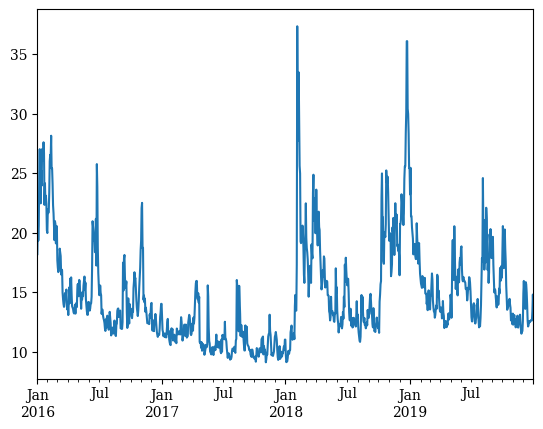

In [57]:
df.VIX["2016":"2019"].plot()

<AxesSubplot: >

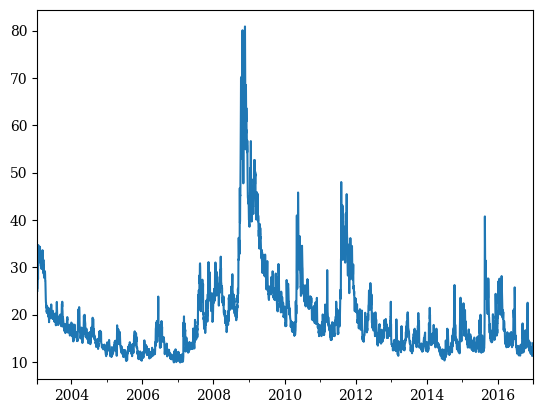

In [55]:
train_df.VIX.plot()

<AxesSubplot: >

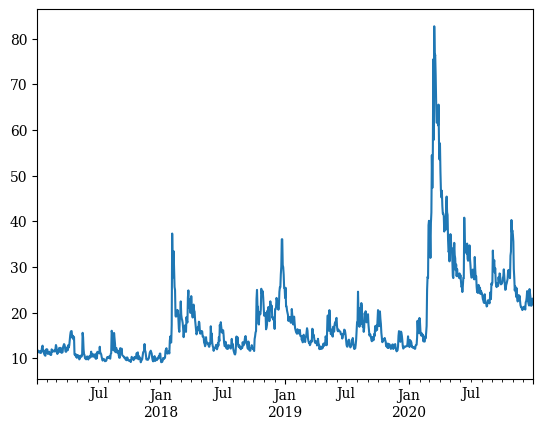

In [53]:
val_df.VIX.plot()

<AxesSubplot: >

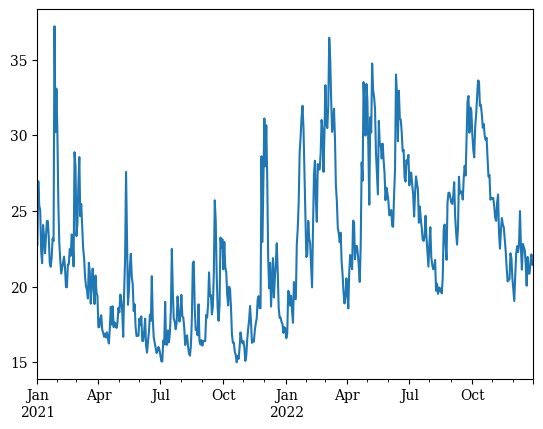

In [52]:
test_df.VIX.plot()

# Interpretation

For now, think we should run one model based on feature selection and one including all data, and compare their results on the test set